In [1]:
n_try = 1

model_names = [
               'CNN'
]

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from os.path import isdir
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

In [4]:
class DataProperties:
    main_dir = '/content/drive/MyDrive/ML/Datasets/5.Unox/'
    # validation_dir = main_dir + 'validation/'
    train_dir = main_dir + 'train/'
    test_dir = main_dir + 'test/'

    hackathon_dir = f'/content/drive/MyDrive/ML/Unox/{n_try}/'
    model_save_dir = hackathon_dir + 'Models/'
    histories_dir = hackathon_dir + 'Histories/'

# Prepare Data

In [5]:
target_shapes = {
    'CNN': (256, 256)
}

In [7]:
def preprocess(image):
    image = image / 255.
    return image

def prepare_validation_data(target_shape):

    val_use = 1  # 0.4

    val_generator = ImageDataGenerator(
        validation_split = 1 - val_use,

        preprocessing_function = preprocess,
        # samplewise_center = 
        # featurewise_center = 

        # width_shift_range = width_shift_range,
        # height_shift_range = height_shift_range,
        # rotation_range = rotation_range,
        # horizontal_flip = True,
        # vertical_flip = True,

        # brightness_range = 
        # zoom_range = zoom_range
    )

    val_flow = val_generator.flow_from_directory(
        directory = DataProperties.test_dir,

        target_size = target_shape,
        color_mode = 'rgb',
        # classes = 
        class_mode = 'sparse',
        # batch_size = None,
        subset = 'training',
        shuffle = False,
        seed = 123
    )

    print(f'Use {val_flow.n} images for validation flow')

    return val_flow

test_flow = prepare_validation_data(
    target_shape = target_shapes['CNN']
)

Found 100 images belonging to 2 classes.
Use 100 images for validation flow


(32, 256, 256, 3) 1.0


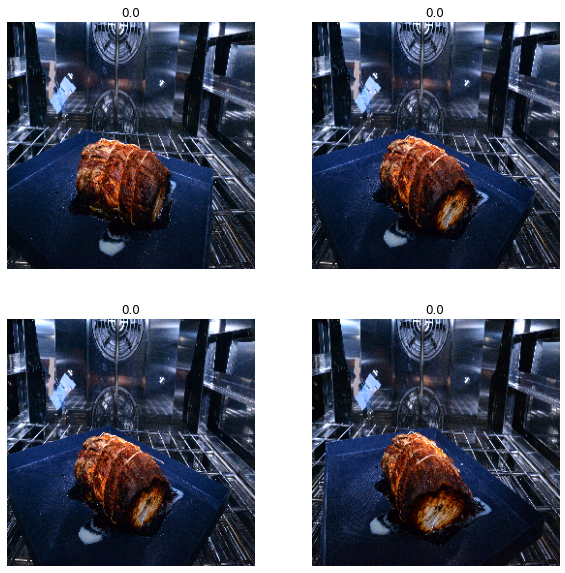

In [12]:
def visualize(batch, labels, n_subplots, class_indices, figsize = (15, 15)):
    plt.figure(figsize = figsize)
    for i in range(n_subplots): #(batch_size):
        ax = plt.subplot(
            int(np.sqrt(n_subplots)), 
            int(np.sqrt(n_subplots)), 
            i + 1
        )
        plt.imshow(batch[i])
        plt.title(labels[i])
        # plt.title(get_class_name(class_indices, labels[i]))
        plt.axis("off")

def visualize_flow(n, flow):

    how_many_to_show = n
    # flow = train_flow
    for _ in range(1):
        batch, labels = flow.next()
        print(batch.shape, np.max(batch))
        assert np.max(batch) <= 1.01
        assert np.min(batch) >= 0.0
        
        visualize(
            batch,
            labels,
            how_many_to_show,
            class_indices = flow.class_indices,
            figsize=(10, 10)
        )

visualize_flow(
    4,
    test_flow
)

In [13]:
test_flow.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

# Load models

In [14]:
DataProperties.model_save_dir

'/content/drive/MyDrive/ML/Unox/1/Models/'

In [8]:
def load_all_models(names_list):

    loaded_models = {
        name: load_model(f'{DataProperties.model_save_dir}{name}/') for name in names_list
    }

    return loaded_models

loaded_models = load_all_models(
    model_names
)

In [9]:
loaded_models['CNN'].summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 52, 52, 96)        720096    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 25, 25, 96)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 5, 5, 96)          331872    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 2, 2, 96)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 384)               0         
                                                                 
 dense_4 (Dense)             (None, 10)               

In [10]:
loaded_models['CNN'].evaluate(
    test_flow
)

4/4 [==============================] - 84s 24s/step - loss: 6.0697 - accuracy: 0.5000


[6.069662094116211, 0.5]

# Load histories

In [15]:
from os.path import isfile
import pandas as pd

def load_histories(model_names):
    res = {n: None for n in model_names}

    for name in model_names:
        history_dir = f'{DataProperties.histories_dir}'
        assert(isdir(history_dir))

        file_path = f'{history_dir}{name}_history.csv'
        assert isfile(file_path)

        res[name] = pd.read_csv(file_path)
    return res


loaded_histories = load_histories(
    model_names
)

# Plot learning curves

In [16]:
def plot_metrics_history(history_df, metrics_name):
    fig, ax = plt.subplots()

    plot_d = dict(
        marker = 'o',
        markerfacecolor = 'white'
    )

    axis_d = dict(
        fontsize = 20
    )

    ax.plot(history_df[f'{metrics_name}'], **plot_d)
    ax.plot(history_df[f'val_{metrics_name}'], **plot_d)


    ax.set_xlabel('Epoch', **axis_d)
    ax.set_ylabel(f'Metrics: {metrics_name}', **axis_d)
    ax.set_title('Metrics VS epoch', **axis_d)

    ax.grid()
    legend_size = 15
    ax.legend(['train', 'validation'], prop = {'size': legend_size})

In [17]:
loaded_histories['CNN'].head()

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy
0,0,1.113917,0.415094,0.828387,0.583333
1,1,0.834907,0.509434,0.662616,0.500000
2,2,0.606876,0.669811,0.446789,0.937500
3,3,0.485187,0.858491,0.504519,0.895833
4,4,0.360872,0.886792,0.384094,0.937500


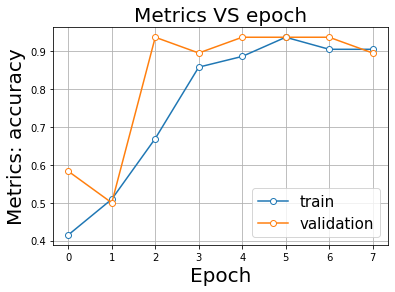

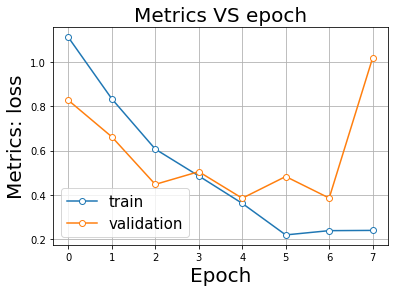

In [19]:
plot_metrics_history(
    loaded_histories['CNN'],
    metrics_name = 'accuracy'
)

plot_metrics_history(
    loaded_histories['CNN'],
    metrics_name = 'loss'
)

# Compare number of trainable parameters

In [20]:
def calc_parameters(model):
    trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
    nonTrainableParams = np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])
    return int(trainableParams + nonTrainableParams)

calc_parameters(
    loaded_models['CNN']
)

1055829